In [ ]:
%load_ext autoreload
%autoreload 2

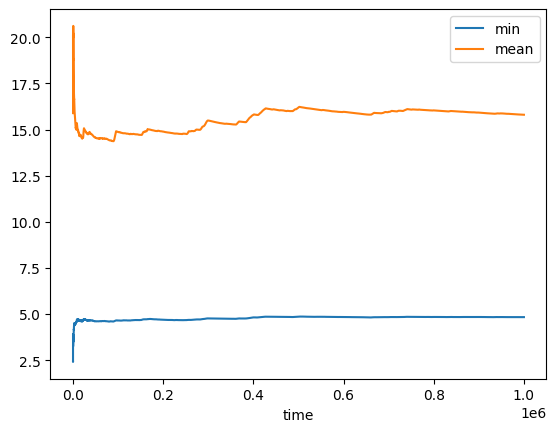

In [49]:
import functools
import jax
import jax.numpy as jnp
import jax_flock as jf
import matplotlib.pyplot as plt
import stats

params = jf.Params(
    weight_forward  = 0.20,
    weight_separate = 1.00,
    weight_align    = 0.30,
    weight_cohere   = 0.60,
    weight_avoid    = 0.80
)

config = jf.Config(
    boid_count = 25,
    sphere_radius = 30.0
)

initial_state = jf.init_state(config, jax.random.PRNGKey(0))
def next_state(state):
    return jf.next_state(params, config, 1/60, state)

def J(state):
    dists = jf.pairwise_distances(state)
    return jnp.hstack([jnp.min(dists), jnp.mean(dists)])

res = stats.time_average_with_history(initial_state, next_state, 1_000_000, J)
min_sep, mean_sep = res.T

plt.plot(min_sep, label='min')
plt.plot(mean_sep, label='mean')
plt.xlabel('time')
plt.legend()

In [ ]:

dF_dsep = jax.jacfwd(F, argnums=0)
# print(dF_dsep(initial_state, params.weight_separate))

def G(state):
    return jf.next_state(params, config, 1 / 60, state)

def Gn(state, n_steps):
    def step(state):
        return jf.next_state(params, config, 1 / 60, state)
    return jax.lax.fori_loop(0, n_steps, lambda i, state: step(state), state)

# dG_dstate = jax.jacfwd(G, argnums=0)
# pos_pos = dG_dstate(initial_state).position.position.reshape(-1, config.boid_count * 3)
# L = jnp.linalg.eigvals(pos_pos)
# with jnp.printoptions(threshold=jnp.inf):
    # print(pos_pos)
# print(jnp.real(L))

dGn_dstate = jax.jacfwd(lambda state: Gn(state, 100), argnums=0)
pos_pos = dGn_dstate(initial_state).position.position.reshape(-1, config.boid_count * 3)
L = jnp.linalg.eigvals(pos_pos)
print(jnp.real(L))
print(jnp.real(L) < 0)